In [2]:
import os
import sys
import torch
import json
import plotly.express as px
from transformer_lens import utils
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../scripts")
from error_eval import *
from plots import *
torch.set_grad_enabled(False)

In [4]:
cwd = os.getcwd()
cwd = cwd.split("notebooks")[0]
print(cwd)

/n/data2/hms/dbmi/sunyaev/lab/dlee/ai_safety/sae_pathology/


In [66]:
directory = "/n/data2/hms/dbmi/sunyaev/lab/dlee/ai_safety/sae_pathology/scripts/results/error_extrapolation_results/gpt2_resid_pre/"

model_id = "jup3glm9"

df = pd.read_csv(directory + f"e2e_{model_id}_layer_6_pos_all.csv")
# df = df[df["position"] != 0]

In [67]:
mean_df = pd.DataFrame(df.mean(axis=0)).T

In [68]:
mean_df_melt = pd.melt(mean_df, id_vars=['reconstruction_error'], value_vars=col_names, ignore_index=False)
mean_df_melt["error_length"] = mean_df_melt["variable"].str.split("_", expand = True)[2].astype(int)

In [69]:
mean_df_melt

,reconstruction_error,variable,value,error_length
0,22.49763,error_length_1_kl,0.000274,1
0,22.49763,error_length_11_kl,0.039313,11
0,22.49763,error_length_21_kl,0.184341,21
0,22.49763,error_length_31_kl,0.517373,31
0,22.49763,error_length_41_kl,1.024723,41
0,22.49763,error_length_51_kl,1.601977,51
0,22.49763,error_length_61_kl,2.193175,61
0,22.49763,error_length_71_kl,2.788749,71
0,22.49763,error_length_81_kl,3.367443,81
0,22.49763,error_length_91_kl,3.902656,91


<Axes: xlabel='error_length', ylabel='value'>

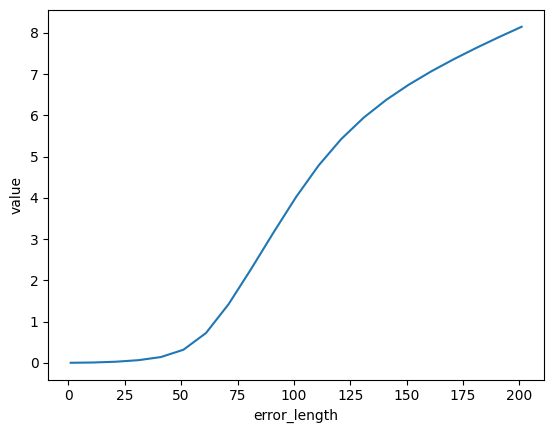

In [64]:
## for e2e SAE 4d5ksz89

sns.lineplot(data=mean_df_melt, x="error_length", y="value")


<Axes: xlabel='error_length', ylabel='value'>

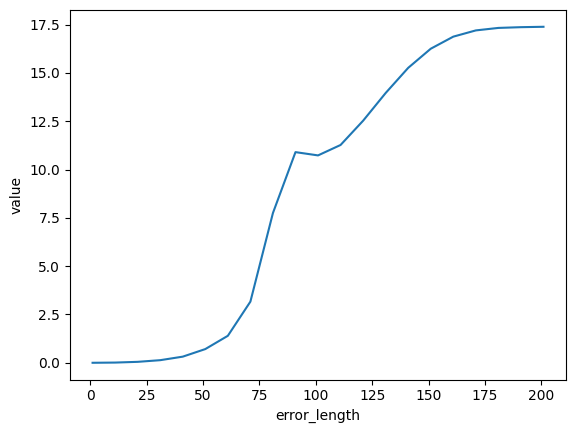

In [51]:
## for e2e SAE 4zcbb4au

sns.lineplot(data=mean_df_melt, x="error_length", y="value")

In [16]:
col_names = [f'error_length_{length}_kl' for length in range(1, 211, 10)]

# Get model names

In [1]:
from e2e_sae.scripts.analysis.utils import create_run_df, get_df_gpt2
df = get_df_gpt2()

performance_df = df.copy()

#get models that were used in the performance plot of the paper
performance_df = df.loc[(df["ratio"] == 60) & (df["seed"] == 0) & (df["n_samples"] == 400_000)]

# Ignore specialised runs
performance_df = performance_df.loc[
    ~performance_df["name"].str.contains("seed-comparison")
    & ~performance_df["name"].str.contains("lr-comparison")
    & ~performance_df["name"].str.contains("lower-downstream")
    & -performance_df["name"].str.contains("e2e-local")
    & ~performance_df["name"].str.contains("recon-all")
    & ~performance_df["name"].str.contains("misc_")]

columns_list = ["id", "sae_pos", "run_type", "layer", "L0", "CELossIncrease", "alive_dict_elements"]
df_local = performance_df[(performance_df["layer"] == 6) & (performance_df["run_type"] == "local")].sort_values("L0")
df_e2e = performance_df[(performance_df["layer"] == 6) & (performance_df["run_type"] == "e2e")].sort_values("L0")
df_downstream = performance_df[(performance_df["layer"] == 6) & (performance_df["run_type"] == "downstream")].sort_values("L0")

Processing runs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:11<00:00, 25.85it/s]


In [7]:
df_e2e["run_type"]

251    e2e
250    e2e
249    e2e
248    e2e
247    e2e
246    e2e
Name: run_type, dtype: object

In [71]:
len(df_e2e) + len(df_local) + len(df_downstream)

22

# Draw Extrapolation Plots

In [80]:
df_interest = pd.concat([df_local, df_e2e, df_downstream])

df_interest = pd.concat([df_local, df_e2e, df_downstream]).reset_index(drop = True)
# df_interest = df_interest[(df_interest["L0"] > 35)].reset_index(drop = True)

pos = 'all'
# layers = list(range(12))
layers = [6]
sae_name = 'gpt2_resid_pre'

model_list = [f"e2e_{x}" for x in df_interest["id"]]

result_dfs = {}
for i in range(len(model_list)):
    data_path = os.path.join(
        cwd + '/results/error_extrapolation_results',
        sae_name,
        f'{model_list[i]}_layer_6_pos_{pos}.csv',
    )
    result_dfs[i] = pd.read_csv(data_path)
    

model_names_list = [f"Braun et al. \n$SAE_{run_type}$ \nL0 = {x:.2f}" for (x, run_type) in zip(df_interest["L0"], df_interest["run_type"])]


mean_df = pd.DataFrame({
        l: result_dfs[l].mean(axis=0) for l in range(len(model_names_list))
    }).T

mean_df["L0"] = df_interest["L0"]
mean_df["type"] = df_interest["run_type"]

In [81]:
mean_df

,token,position,loss,error_length_1_loss,error_length_1_kl,error_length_11_loss,error_length_11_kl,error_length_21_loss,error_length_21_kl,error_length_31_loss,...,error_length_201_loss,error_length_201_kl,sae_l0,sae_l1,reconstruction_error,norm,sae_norm,cos,L0,type
0,4738.867746,63.0,3.557865,3.555771,0.000234,3.569024,0.039387,3.744713,0.242880,4.320815,...,12.024907,8.677073,9.940678,93.285198,36.059806,102.278208,82.296992,0.900423,10.271713,local
1,4738.867746,63.0,3.557865,3.555722,0.000263,3.570509,0.041501,3.725594,0.224245,4.186103,...,11.539696,8.178201,16.954113,110.142098,29.591295,102.278208,88.185066,0.932581,17.468240,local
2,4738.867746,63.0,3.557865,3.555970,0.000275,3.573285,0.040932,3.710517,0.201841,4.072998,...,11.072661,7.689569,29.680497,127.461203,24.628616,102.278208,92.561010,0.952543,30.945175,local
3,4738.867746,63.0,3.557865,3.556109,0.000274,3.573399,0.039313,3.696693,0.184341,4.011661,...,10.688512,7.286177,40.660933,138.028827,22.497630,102.278208,94.373836,0.960076,42.798630,local
4,4738.867746,63.0,3.557865,3.555939,0.000271,3.570574,0.038154,3.683892,0.174513,3.970951,...,10.520370,7.129909,50.513713,145.083386,21.354410,102.278208,95.215543,0.964020,53.223964,local
5,4738.867746,63.0,3.557865,3.555952,0.000266,3.569843,0.036914,3.675834,0.165285,3.939050,...,10.213435,6.820443,66.485167,154.668322,20.072467,102.278208,96.156254,0.968153,69.426438,local
6,4738.867746,63.0,3.557865,3.555845,0.000257,3.566473,0.034824,3.658963,0.151154,3.887912,...,9.978464,6.592052,96.483264,169.283954,18.611699,102.278208,97.123783,0.972743,102.580427,local
7,4738.867746,63.0,3.557865,3.556474,0.000236,3.570274,0.031103,3.653394,0.130833,3.848251,...,9.580158,6.145348,175.879770,197.522936,16.504589,102.278208,98.395249,0.978490,183.948012,local
8,4738.867746,63.0,3.557865,3.556491,0.000215,3.567565,0.027696,3.637651,0.113620,3.799099,...,8.936217,5.501217,510.259476,277.317539,13.234724,102.278208,99.820891,0.986301,512.987541,local
9,4738.867746,63.0,3.557865,3.557959,0.000076,3.568595,0.010976,3.604812,0.048816,3.686677,...,20.701561,17.385255,23.053423,18.750162,96.847381,102.278208,10.764572,0.463443,21.028400,e2e


In [82]:
col_names = [f'error_length_{length}_kl' for length in range(1, 211, 10)]
mean_df_melt_kl = pd.melt(mean_df, id_vars=['reconstruction_error', 'L0', 'type'], value_vars=col_names, ignore_index=False)
mean_df_melt_kl["metric"] = "KL"

col_names = [f'error_length_{length}_loss' for length in range(1, 211, 10)]
mean_df_melt_loss = pd.melt(mean_df, id_vars=['reconstruction_error', 'L0', 'type'], value_vars=col_names, ignore_index=False)
mean_df_melt_loss["metric"] = "Loss"

mean_df_melt = pd.concat([mean_df_melt_kl, mean_df_melt_loss])
mean_df_melt["error_length"] = mean_df_melt["variable"].str.split("_", expand = True)[2].astype(int)

In [83]:
mean_df_melt["L0"] = [f"{x:.1f}" for x in mean_df_melt["L0"]]
mean_df_melt["L0"] = mean_df_melt["L0"].astype(float)

In [84]:
mean_df_melt["L0"

,reconstruction_error,L0,type,variable,value,metric,error_length
0,36.059806,10.3,local,error_length_1_kl,0.000234,KL,1
1,29.591295,17.5,local,error_length_1_kl,0.000263,KL,1
2,24.628616,30.9,local,error_length_1_kl,0.000275,KL,1
3,22.497630,42.8,local,error_length_1_kl,0.000274,KL,1
4,21.354410,53.2,local,error_length_1_kl,0.000271,KL,1
...,...,...,...,...,...,...,...
17,43.970155,46.5,downstream,error_length_201_loss,13.504122,Loss,201
18,39.060228,58.8,downstream,error_length_201_loss,12.763907,Loss,201
19,32.357821,90.0,downstream,error_length_201_loss,12.272878,Loss,201
20,27.635548,131.3,downstream,error_length_201_loss,12.005334,Loss,201


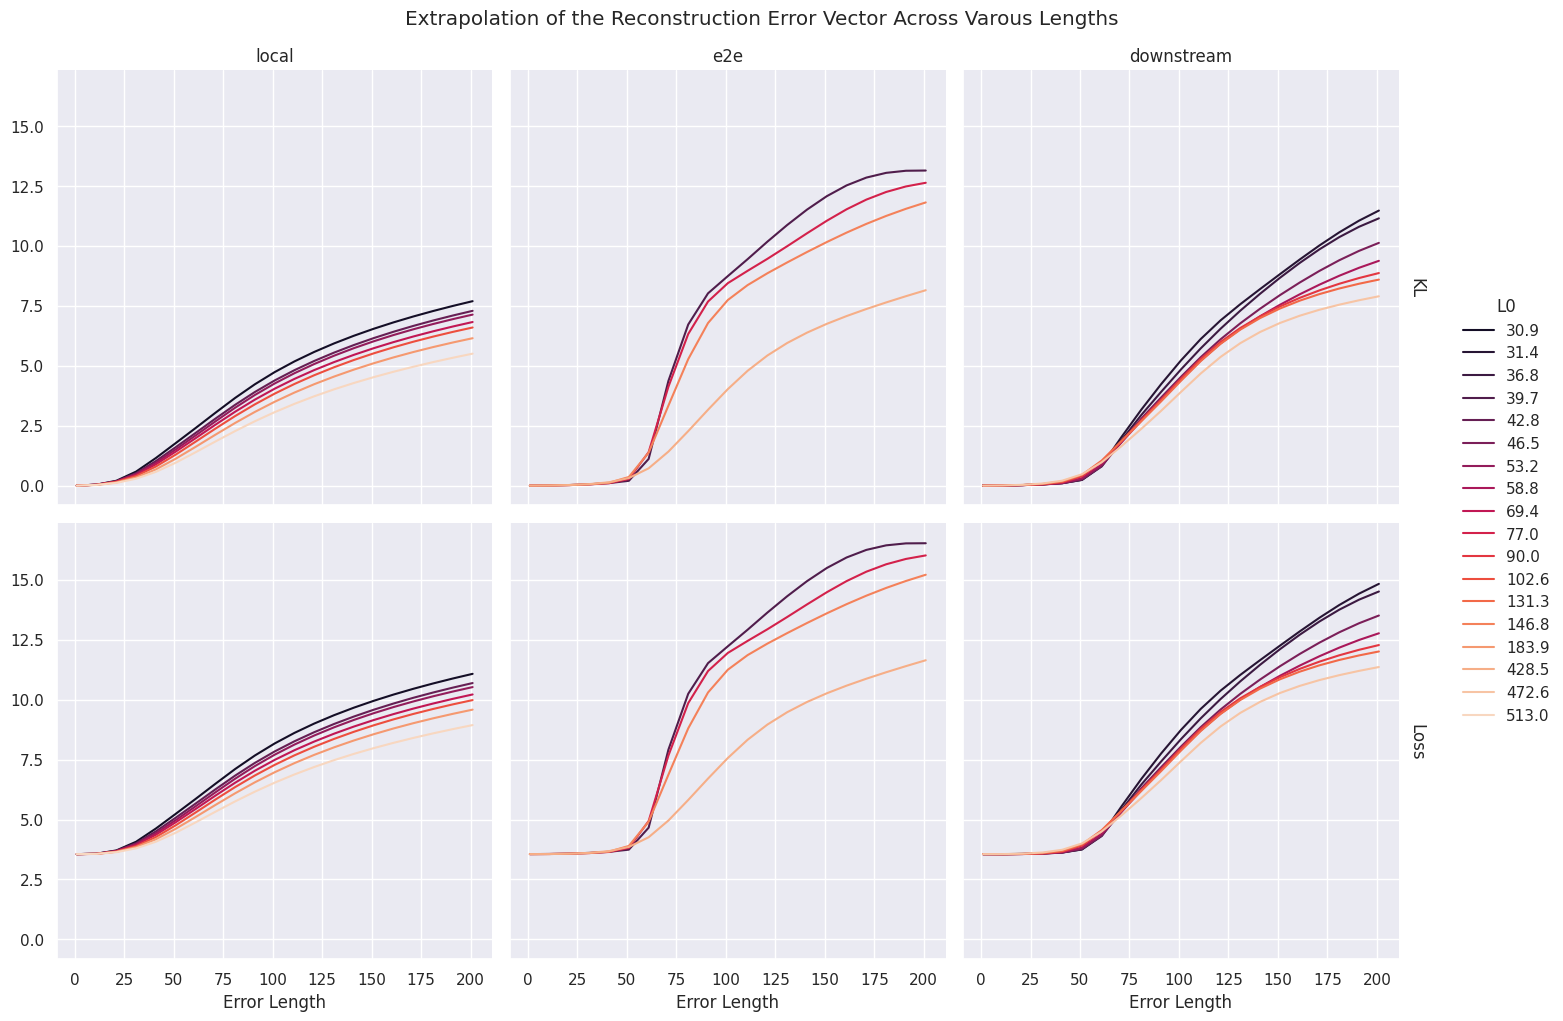

In [94]:
sns.set_theme(style="darkgrid")

mean_df_melt_plot = mean_df_melt[(mean_df_melt["L0"] >= 30)]

g = sns.FacetGrid(mean_df_melt_plot, row = "metric", col="type", height=5, margin_titles=True, hue = "L0", 
                  palette = 'rocket')

g.map(sns.lineplot, "error_length", "value")

g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.fig.suptitle(f'Extrapolation of the Reconstruction Error Vector Across Varous Lengths', y = 1.02)

g.set(xlabel="Error Length", ylabel = None)
g.add_legend()

plt.savefig("extrapolation_error.svg", format="svg", bbox_inches="tight")

In [87]:
mean_df_melt[mean_df_melt["error_length"] <=51]

,reconstruction_error,L0,type,variable,value,metric,error_length
0,36.059806,10.3,local,error_length_1_kl,0.000234,KL,1
1,29.591295,17.5,local,error_length_1_kl,0.000263,KL,1
2,24.628616,30.9,local,error_length_1_kl,0.000275,KL,1
3,22.497630,42.8,local,error_length_1_kl,0.000274,KL,1
4,21.354410,53.2,local,error_length_1_kl,0.000271,KL,1
...,...,...,...,...,...,...,...
17,43.970155,46.5,downstream,error_length_51_loss,3.777826,Loss,51
18,39.060228,58.8,downstream,error_length_51_loss,3.830541,Loss,51
19,32.357821,90.0,downstream,error_length_51_loss,3.910317,Loss,51
20,27.635548,131.3,downstream,error_length_51_loss,3.959643,Loss,51


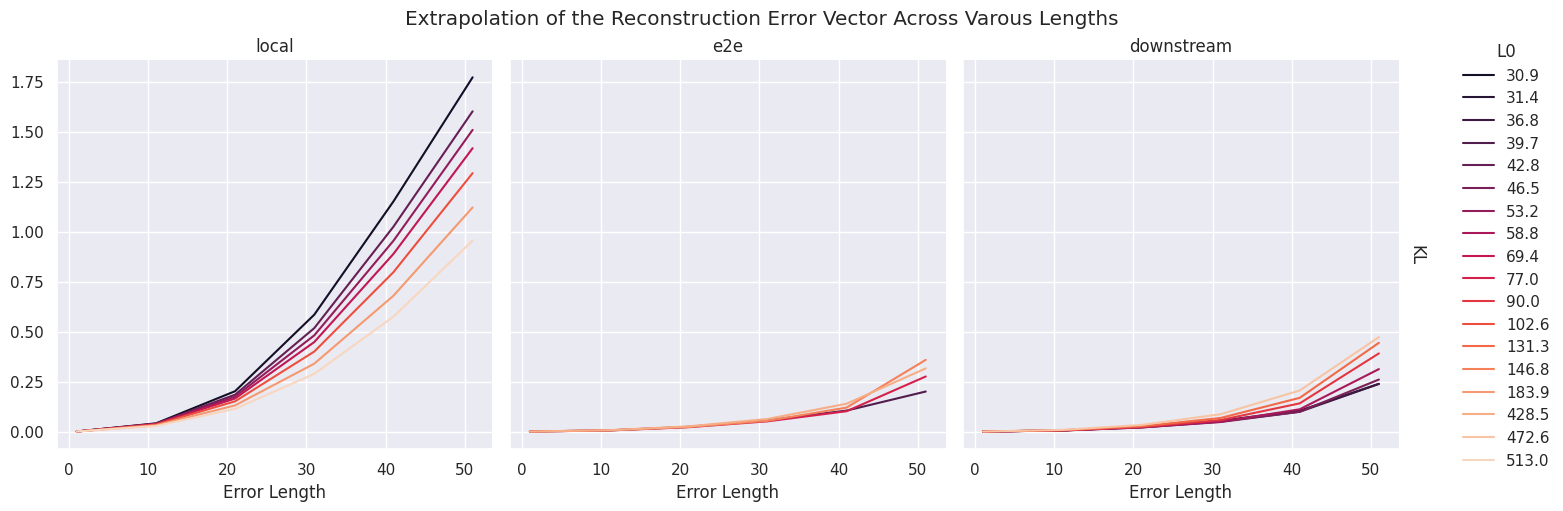

In [91]:
sns.set_theme(style="darkgrid")

mean_df_melt_plot = mean_df_melt[(mean_df_melt["L0"] >= 30) & (mean_df_melt["error_length"] <= 51) & (mean_df_melt["metric"] == "KL")]

g = sns.FacetGrid(mean_df_melt_plot, row = "metric", col="type", height=5, margin_titles=True, hue = "L0", 
                  palette = 'rocket')

g.map(sns.lineplot, "error_length", "value")

g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.fig.suptitle(f'Extrapolation of the Reconstruction Error Vector Across Varous Lengths', y = 1.02)

g.set(xlabel="Error Length", ylabel = None)
g.add_legend()

In [54]:
df_interest = pd.concat([df_local, df_e2e, df_downstream])
df_interest = df_interest[(df_interest["L0"] > 35)].reset_index(drop = True)

In [127]:
pos = 'all'
# layers = list(range(12))
layers = [6]
sae_name = 'gpt2_resid_pre'

model_list = [f"e2e_{x}" for x in df_interest["id"]]

result_dfs = {}
for i in range(len(model_list)):
    data_path = os.path.join(
        cwd + '/error_eval_results',
        sae_name,
        f'{model_list[i]}_layer_6_pos_{pos}.csv',
    )
    result_dfs[i] = pd.read_csv(data_path)
    result_dfs[i]["norm_ratio"] = result_dfs[i]["sae_norm"]/result_dfs[0]["norm"]

model_names_list = [f"Braun et al. \n$SAE_{{e2e}}$ \nL0 = {x:.2f}" for x in df_interest["L0"]]


mean_df = pd.DataFrame({
        l: result_dfs[l].mean(axis=0) for l in range(len(model_names_list))
    }).T

mean_df["L0"] = df_interest["L0"]
mean_df["type"] = df_interest["run_type"]

In [158]:
# mean_df["L0"] = [f"{x:.2f}" for x in mean_df["L0"]]
mean_df["L0"] = mean_df["L0"].astype(float)

In [148]:
mean_df

,token,position,loss,substitution_loss,substitution_kl,norm_corrected_substitution_loss,norm_corrected_substitution_kl,cos_corrected_substitution_loss,cos_corrected_substitution_kl,l2_error_preserving_substitution_loss,...,mean_ablation_kl,sae_l0,sae_l1,reconstruction_error,norm,sae_norm,cos,norm_ratio,L0,type
0,4738.867746,63.0,3.557865,3.740642,0.229593,3.760289,0.248479,3.565278,0.007286,3.634387,...,5.283527,40.660933,138.028827,22.497630,102.278208,94.373838,0.960076,0.899714,42.80,local
1,4738.867746,63.0,3.557865,3.698316,0.189682,3.713387,0.204176,3.563941,0.005842,3.626248,...,5.283527,50.513713,145.083386,21.354410,102.278208,95.215543,0.964020,0.910483,53.22,local
2,4738.867746,63.0,3.557865,3.666962,0.154479,3.677946,0.165092,3.562532,0.004489,3.617041,...,5.283527,66.485167,154.668322,20.072467,102.278208,96.156254,0.968153,0.922236,69.43,local
3,4738.867746,63.0,3.557865,3.629418,0.122456,3.636425,0.129308,3.561583,0.003261,3.608255,...,5.283527,96.483264,169.283954,18.611699,102.278208,97.123783,0.972743,0.934783,102.58,local
4,4738.867746,63.0,3.557865,3.608510,0.079646,3.612754,0.083497,3.559753,0.002072,3.596668,...,5.283527,175.879770,197.522936,16.504589,102.278208,98.395249,0.978490,0.950195,183.95,local
5,4738.867746,63.0,3.557865,3.577006,0.043873,3.578736,0.045340,3.558596,0.001024,3.581848,...,5.283527,510.259476,277.317539,13.234724,102.278208,99.820891,0.986301,0.968101,512.99,local
6,4738.867746,63.0,3.557865,3.617729,0.122186,3.971430,0.442919,4.169816,0.666079,6.797677,...,5.283527,44.115774,64.343341,74.836169,102.278208,36.390879,0.835731,0.423581,39.68,e2e
7,4738.867746,63.0,3.557865,3.582738,0.075825,3.733876,0.195588,3.709804,0.193319,6.452552,...,5.283527,85.139187,112.566263,61.415820,102.278208,50.781455,0.900055,0.584175,77.05,e2e
8,4738.867746,63.0,3.557865,3.571621,0.048995,3.635303,0.094957,3.591098,0.065200,5.739427,...,5.283527,160.490219,183.393711,46.519907,102.278208,67.017225,0.936675,0.728556,146.82,e2e
9,4738.867746,63.0,3.557865,3.568404,0.027440,3.577641,0.032565,3.551617,0.007901,4.552629,...,5.283527,455.386434,380.288574,30.059134,102.278208,87.079444,0.965151,0.911352,428.47,e2e


In [63]:
mean_df_melt = pd.melt(mean_df, id_vars=['L0', 'type'], value_vars=kl_all_cols, value_name = "kl")

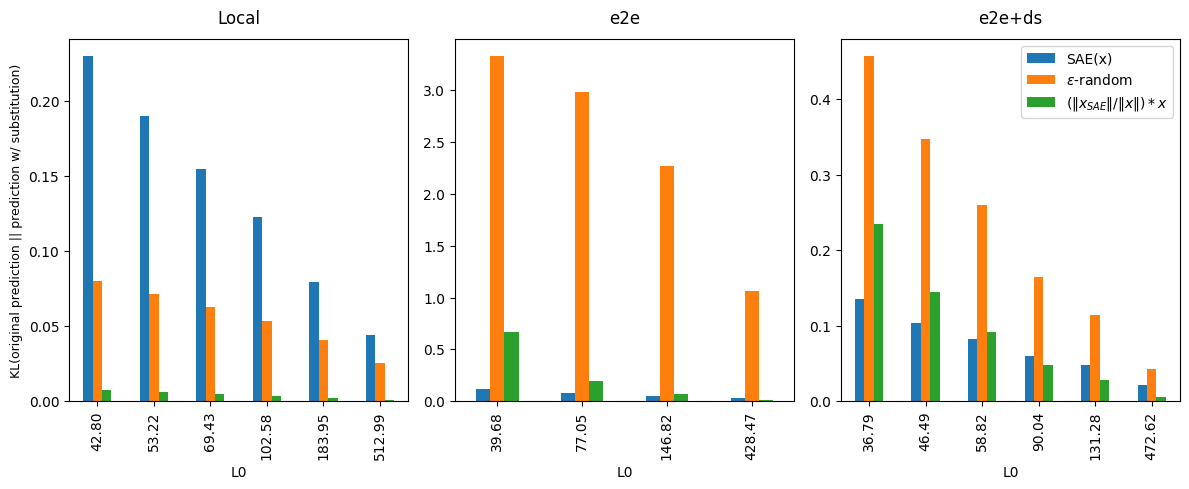

In [116]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
columns = kl_main_cols

mean_df_plot = mean_df[mean_df["type"] == "local"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[0])
axes[0].set_ylabel('KL(original prediction || prediction w/ substitution)', fontsize=9)
axes[0].set_title('Local', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "e2e"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[1])
axes[1].set_title('e2e', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "downstream"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[2])
axes[2].set_title('e2e+ds', y=1.02)

for i in range(2):
    axes[i].get_legend().remove()

# for i in range(3):
#     axes[i].set_ylim([0, 3.5])

fig.tight_layout()

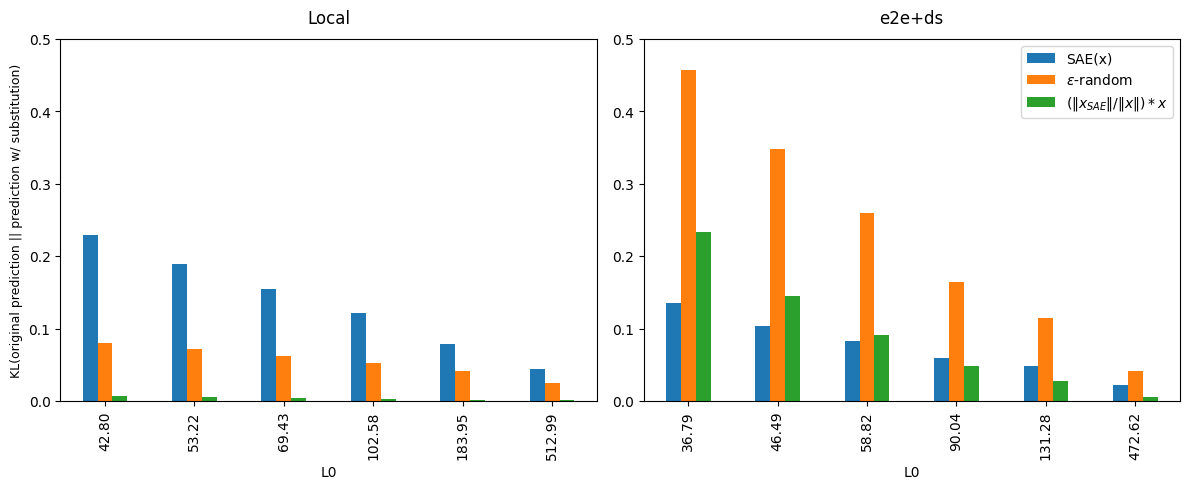

In [139]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
columns = kl_main_cols

mean_df_plot = mean_df[mean_df["type"] == "local"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[0])
axes[0].set_ylabel('KL(original prediction || prediction w/ substitution)', fontsize=9)
axes[0].set_title('Local', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "downstream"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[1])
axes[1].set_title('e2e+ds', y=1.02)

for i in range(1):
    axes[i].get_legend().remove()

for i in range(2):
    axes[i].set_ylim([0, 0.5])

fig.tight_layout()

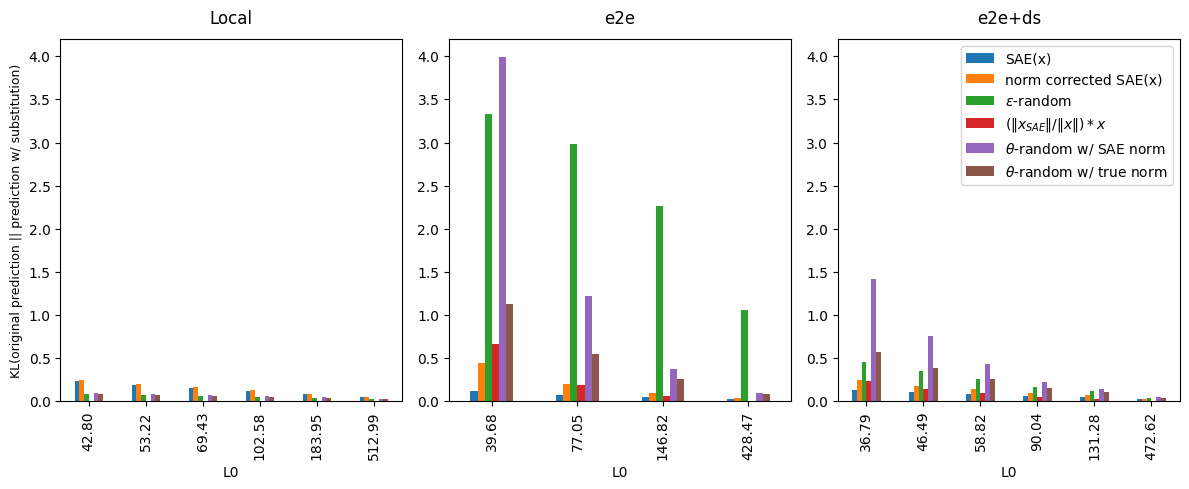

In [120]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
columns = kl_all_cols

mean_df_plot = mean_df[mean_df["type"] == "local"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[0])
axes[0].set_ylabel('KL(original prediction || prediction w/ substitution)', fontsize=9)
axes[0].set_title('Local', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "e2e"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[1])
axes[1].set_title('e2e', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "downstream"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[2])
axes[2].set_title('e2e+ds', y=1.02)

for i in range(2):
    axes[i].get_legend().remove()

for i in range(3):
    axes[i].set_ylim([0, 4.2])

fig.tight_layout()

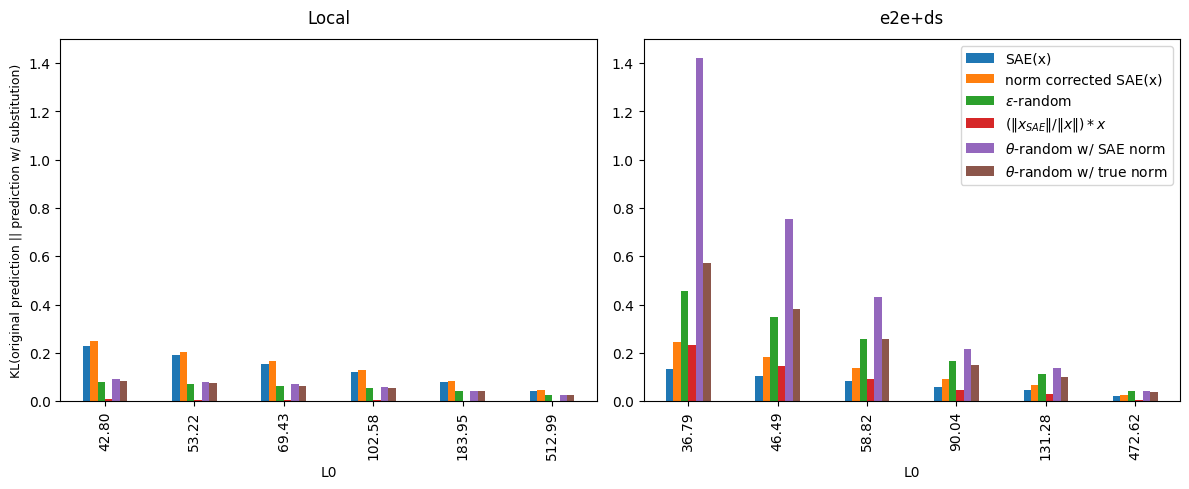

In [141]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
columns = kl_all_cols

mean_df_plot = mean_df[mean_df["type"] == "local"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[0])
axes[0].set_ylabel('KL(original prediction || prediction w/ substitution)', fontsize=9)
axes[0].set_title('Local', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "downstream"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[1])
axes[1].set_title('e2e+ds', y=1.02)

for i in range(1):
    axes[i].get_legend().remove()

for i in range(2):
    axes[i].set_ylim([0, 1.5])

fig.tight_layout()

In [128]:
mean_df.columns

Index(['token', 'position', 'loss', 'substitution_loss', 'substitution_kl',
       'norm_corrected_substitution_loss', 'norm_corrected_substitution_kl',
       'cos_corrected_substitution_loss', 'cos_corrected_substitution_kl',
       'l2_error_preserving_substitution_loss',
       'l2_error_preserving_substitution_kl',
       'cos_preserving_substitution_w_sae_norm_loss',
       'cos_preserving_substitution_w_sae_norm_kl',
       'cos_preserving_substitution_w_true_norm_loss',
       'cos_preserving_substitution_w_true_norm_kl', 'zero_ablation_loss',
       'zero_ablation_kl', 'mean_ablation_loss', 'mean_ablation_kl', 'sae_l0',
       'sae_l1', 'reconstruction_error', 'norm', 'sae_norm', 'cos',
       'norm_ratio', 'L0', 'type'],
      dtype='object')

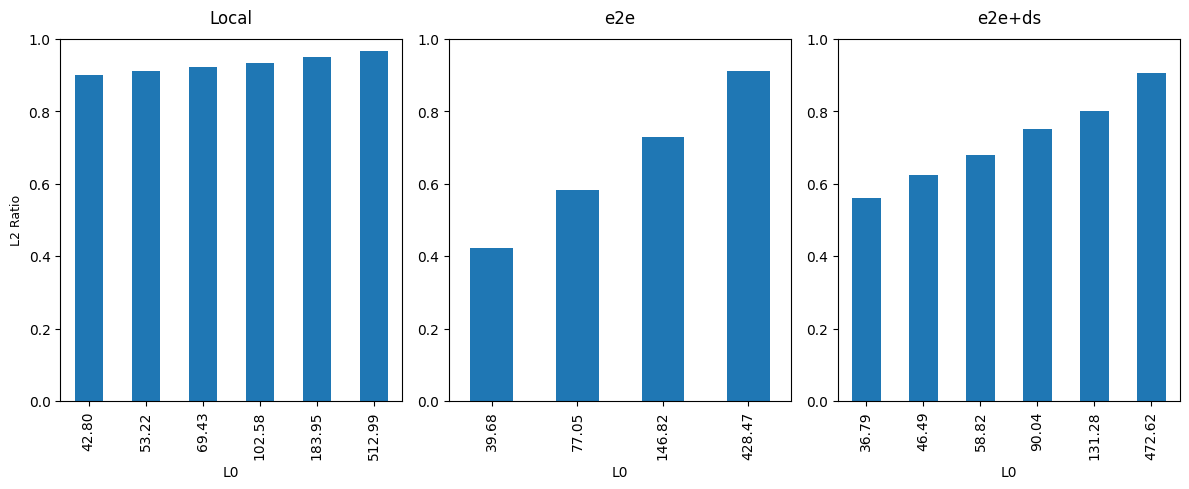

In [136]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
columns = ["norm_ratio"]

mean_df_plot = mean_df[mean_df["type"] == "local"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[0])
axes[0].set_ylabel('L2 Ratio', fontsize=9)
axes[0].set_title('Local', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "e2e"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[1])
axes[1].set_title('e2e', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "downstream"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[2])
axes[2].set_title('e2e+ds', y=1.02)

for i in range(3):
    axes[i].get_legend().remove()
    axes[i].set_ylim([0, 1.0])

# for i in range(3):
#     axes[i].set_ylim([0, 3.5])

fig.tight_layout()

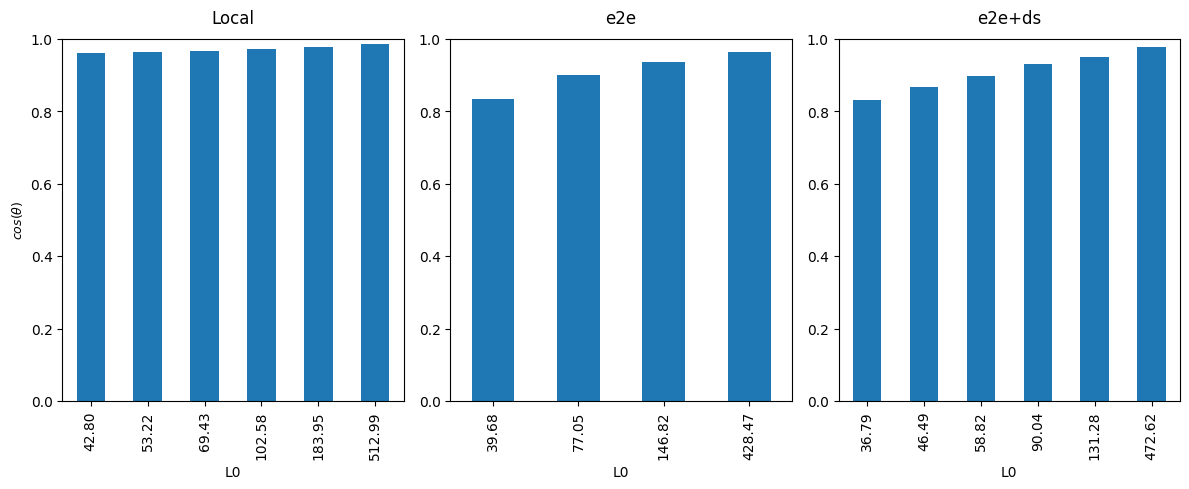

In [149]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
columns = ["cos"]

mean_df_plot = mean_df[mean_df["type"] == "local"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[0])
axes[0].set_ylabel(r'$cos(\theta)$', fontsize=9)
axes[0].set_title('Local', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "e2e"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[1])
axes[1].set_title('e2e', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "downstream"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[2])
axes[2].set_title('e2e+ds', y=1.02)

for i in range(3):
    axes[i].get_legend().remove()
    axes[i].set_ylim([0, 1.0])

# for i in range(3):
#     axes[i].set_ylim([0, 3.5])

fig.tight_layout()

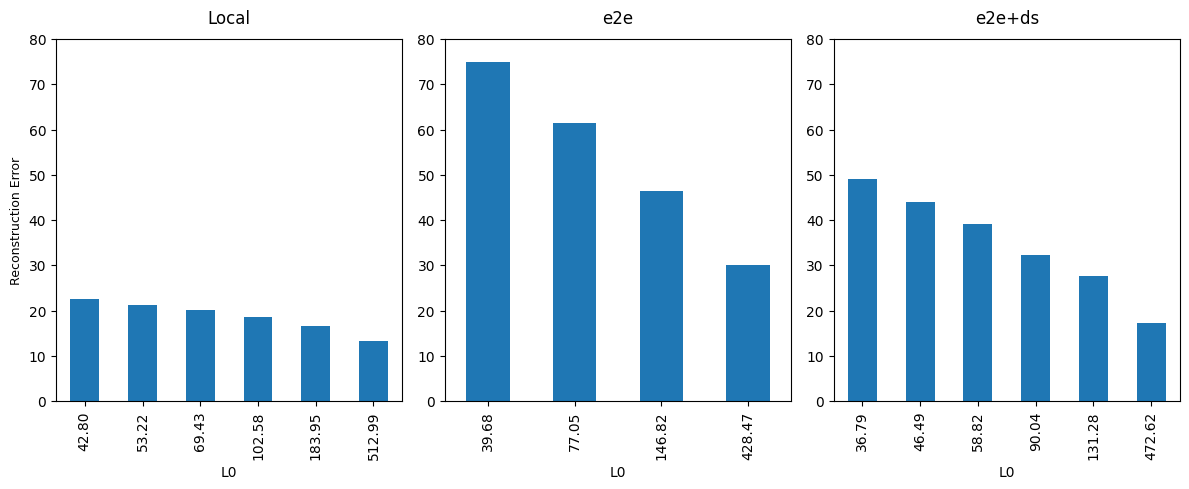

In [153]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
columns = ["reconstruction_error"]

mean_df_plot = mean_df[mean_df["type"] == "local"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[0])
axes[0].set_ylabel(r'Reconstruction Error', fontsize=9)
axes[0].set_title('Local', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "e2e"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[1])
axes[1].set_title('e2e', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "downstream"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", kind='bar', ax=axes[2])
axes[2].set_title('e2e+ds', y=1.02)

for i in range(3):
    axes[i].get_legend().remove()
    axes[i].set_ylim([0, 80])

# for i in range(3):
#     axes[i].set_ylim([0, 3.5])

fig.tight_layout()

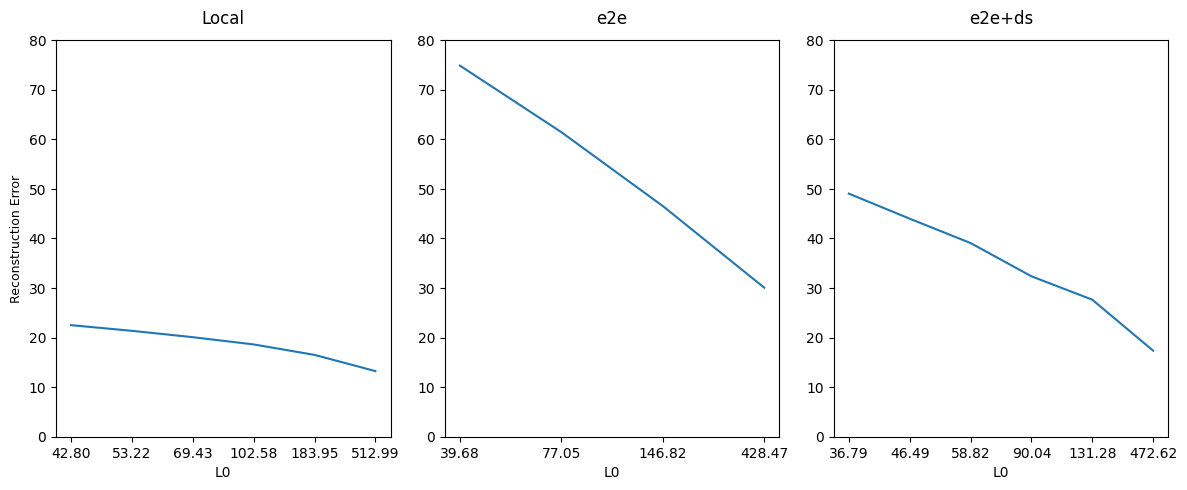

In [154]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
columns = ["reconstruction_error"]

mean_df_plot = mean_df[mean_df["type"] == "local"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", y = "reconstruction_error", ax=axes[0])
axes[0].set_ylabel(r'Reconstruction Error', fontsize=9)
axes[0].set_title('Local', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "e2e"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", y = "reconstruction_error", ax=axes[1])
axes[1].set_title('e2e', y=1.02)

mean_df_plot = mean_df[mean_df["type"] == "downstream"]
mean_df_plot[columns + ["L0"]].rename(columns=kl_col_labels).plot(x = "L0", y = "reconstruction_error", ax=axes[2])
axes[2].set_title('e2e+ds', y=1.02)

for i in range(3):
    axes[i].get_legend().remove()
    axes[i].set_ylim([0, 80])

# for i in range(3):
#     axes[i].set_ylim([0, 3.5])

fig.tight_layout()

<Axes: xlabel='reconstruction_error', ylabel='substitution_kl'>

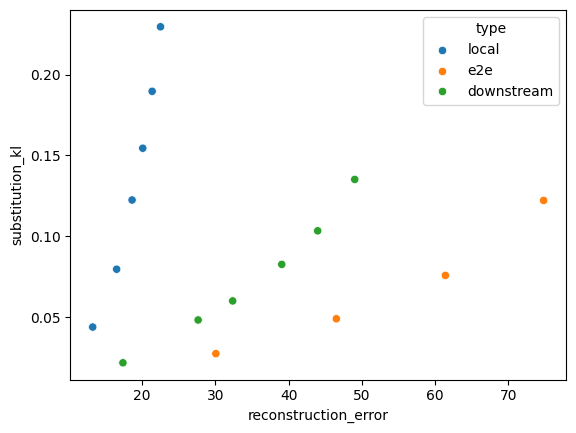

In [161]:
sns.scatterplot(data=mean_df, x="reconstruction_error", y="substitution_kl", hue="type")
